In [9]:
%%capture
!pip install datasetsforecast
!pip install git+https://github.com/Nixtla/neuralforecast.git
!pip install git+https://github.com/Nixtla/hierarchicalforecast.git
!pip install --upgrade hyperopt
!git clone https://github.com/dluuo/HINT.git

In [10]:
from ray.tune.search.hyperopt import HyperOptSearch

In [11]:
# %%capture
import os
import re
import numpy as np
import pandas as pd

from ray import tune

#import wrangled datasets
from HINT.src.data.data import HierarchicalDataset

# Hierarchical data
from datasetsforecast.hierarchical import HierarchicalData

# Reconciliation and evaluation
from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.evaluation import HierarchicalEvaluation, scaled_crps
from hierarchicalforecast.methods import BottomUp, TopDown, MiddleOut, MinTrace, ERM
from hierarchicalforecast.utils import CodeTimer

from neuralforecast import NeuralForecast
from neuralforecast.auto import AutoNHITS, AutoNBEATS, AutoTFT, AutoTCN, AutoLSTM
from neuralforecast.losses.pytorch import PMM, GMM, DistributionLoss


import matplotlib.pyplot as plt

<a name="cell-2"></a>
# 2. Auxiliary Functions

In [12]:
def sort_df_hier(Y_df, S):
    Y_df.unique_id = Y_df.unique_id.astype('category')
    Y_df.unique_id = Y_df.unique_id.cat.set_categories(S.index)
    Y_df = Y_df.sort_values(by=['unique_id', 'ds'])

    return Y_df

In [13]:
def get_hierarchical_crps(data, Y, Y_hat, q_to_pred, model_name='current'):
    hier_idxs   = data['hier_idxs']
    crps_list = []
    for i, idxs in enumerate(hier_idxs):
        # Get the series specific to the hierarchical level
        y     = Y[idxs, :]
        y_hat = Y_hat[idxs, :, :]

        crps  = scaled_crps(y, y_hat, q_to_pred)
        crps_list.append(crps)

    return crps_list

<a name="cell-3"></a>
# 3. Baseline CRPS Function

In [14]:
def run_baselines(dataset, models, scalar_type, verbose=False):
    with CodeTimer('Read and Parse data   ', verbose):
        hdataset = HierarchicalDataset()
        data = hdataset.load_process_data(dataset=dataset)

        #import Y_df
        Y_df = data['Y_df'][data['Y_df']['y'].notna()]
        Y_df['ds'] = pd.to_datetime(Y_df['ds'])  

        #import S, tags, properties
        S, tags = data['S_df'], data['tags']
        frequency, seasonality, horizon = data['freq'], data['seasonality'], data['horizon']

        # --Modeling parameters--
        season_length = seasonality
        horizon_len = horizon
        freq = frequency
        val_size = horizon
        test_size = horizon
        n_windows_cv = test_size//horizon
        n_series = len(Y_df.unique_id.unique())
        num_components = 10
        num_samples = 3
        input_size = 2*horizon

        #create level and quantiles
        level = np.arange(2, 100, 2)
        qs = [[50-l/2, 50+l/2] for l in level] 
        quantiles = np.sort(np.concatenate(qs)/100)

    with CodeTimer('Fit/Predict Model	 ', verbose):
        
        nhits_config = {
            "scaler_type": tune.choice([scalar_type]),
            "hist_exog_list": tune.choice([[f'y_[lag{seasonality}]']]),
            "learning_rate": tune.choice([1e-3, 5e-3]),                                  # Initial Learning rate
            "max_steps": tune.choice([500, 1000, 2000]),                                             # Number of SGD steps
            "input_size": tune.choice([input_size]),                                          # input_size = multiplier * horizon
            "batch_size": tune.choice([64]),                                                   # Number of series in windows
            "windows_batch_size": tune.choice([256]),                                          # Number of windows in batch
            "n_pool_kernel_size": tune.choice([[2, 2, 2], [4, 2, 1]]),                         # MaxPool's Kernelsize
            "n_freq_downsample": tune.choice([[12, 4, 1], [24, 12, 1], [4, 2, 1], [1, 1, 1]]), # Interpolation expressivity ratios
            "mlp_units":  tune.choice([[[512, 512], [512, 512], [512, 512]]]),                 # 2 512-Layers per block for each stack
            "val_check_steps": tune.choice([100]),                                             # Compute validation every 100 steps
            "early_stop_patience_steps": tune.choice([5]),
            "num_lr_decays": tune.choice([-1, 3]),
            # "random_seed": tune.randint(1, 10), 
        }
        nbeats_config = {
            "scaler_type": tune.choice([scalar_type]),
            "hist_exog_list": tune.choice([[f'y_[lag{seasonality}]']]),
            "learning_rate": tune.choice([1e-3, 5e-3]),                                  # Initial Learning rate
            "max_steps": tune.choice([500, 1000, 2000]),                                             # Number of SGD steps
            "input_size": tune.choice([input_size]),                                          # input_size = multiplier * horizon
            "batch_size": tune.choice([64]),                                                   # Number of series in windows
            "val_check_steps": tune.choice([100]),                                             # Compute validation every 100 steps
            "early_stop_patience_steps": tune.choice([5]),
            "num_lr_decays": tune.choice([-1, 3]),
            # "random_seed": tune.randint(1, 10),
        }
        tft_config = {
            "scaler_type": tune.choice([scalar_type]),
            "hist_exog_list": tune.choice([[f'y_[lag{seasonality}]']]),
            "learning_rate": tune.choice([1e-3, 5e-3]),                                  # Initial Learning rate
            "max_steps": tune.choice([500, 1000, 2000]),                                             # Number of SGD steps
            "input_size": tune.choice([input_size]),                                          # input_size = multiplier * horizon
            "batch_size": tune.choice([64]),                                                   # Number of series in windows
            "val_check_steps": tune.choice([100]),                                             # Compute validation every 100 steps
            "early_stop_patience_steps": tune.choice([5]),
            "num_lr_decays": tune.choice([-1, 3]),
            # "random_seed": tune.randint(1, 10),
        }
        tcn_config = {
            "scaler_type": tune.choice([scalar_type]),
            "hist_exog_list": tune.choice([[f'y_[lag{seasonality}]']]),
            "learning_rate": tune.choice([1e-3, 5e-3]),                                  # Initial Learning rate
            "max_steps": tune.choice([500, 1000, 2000]),                                             # Number of SGD steps
            "input_size": tune.choice([input_size]),                                          # input_size = multiplier * horizon
            "batch_size": tune.choice([64]),                                                   # Number of series in windows
            "val_check_steps": tune.choice([100]),                                             # Compute validation every 100 steps
            "early_stop_patience_steps": tune.choice([5]),
            "num_lr_decays": tune.choice([-1, 3]),
            # "random_seed": tune.randint(1, 10),
        }
        lstm_config = {
            "scaler_type": tune.choice([scalar_type]),
            "hist_exog_list": tune.choice([[f'y_[lag{seasonality}]']]),
            "learning_rate": tune.choice([1e-3, 5e-3]),                                  # Initial Learning rate
            "max_steps": tune.choice([500, 1000, 2000]),                                             # Number of SGD steps
            "input_size": tune.choice([input_size]),                                          # input_size = multiplier * horizon
            "batch_size": tune.choice([64]),                                                   # Number of series in windows
            "val_check_steps": tune.choice([100]),                                             # Compute validation every 100 steps
            "early_stop_patience_steps": tune.choice([5]),
            "num_lr_decays": tune.choice([-1, 3]),
            # "random_seed": tune.randint(1, 10),
        }

        model_dict = {
            'NHITS' : AutoNHITS(config=nhits_config,
                            loss=GMM(n_components=num_components, level=list(level)),
                            h=horizon,
                            search_alg=HyperOptSearch(),
                            num_samples=num_samples),
            'NBEATS' : AutoNBEATS(config=nbeats_config,
                            loss=GMM(n_components=num_components, level=list(level)),
                            h=horizon,
                            search_alg=HyperOptSearch(),
                            num_samples=num_samples),
            'TFT' : AutoTFT(config=tft_config,
                            loss=GMM(n_components=num_components, level=list(level)),
                            h=horizon,
                            search_alg=HyperOptSearch(),
                            num_samples=num_samples),
            'TCN' : AutoTCN(config=tft_config,
                            loss=GMM(n_components=num_components, level=list(level)),
                            h=horizon,
                            search_alg=HyperOptSearch(),
                            num_samples=num_samples),
            'LSTM' : AutoLSTM(config=tft_config,
                            loss=GMM(n_components=num_components, level=list(level)),
                            h=horizon,
                            search_alg=HyperOptSearch(),
                            num_samples=num_samples)
        }

        model_list = [model_dict[model] for model in models]

        #fit and predict
        fcst = NeuralForecast(models=model_list, freq=frequency)

        # Obtain forecast predictions
        Y_hat_df = fcst.cross_validation(df=Y_df,
                                         n_windows=None,
                                         val_size=val_size,
                                         test_size=test_size)
        
        #sort raw predictions by uid to make sure they are hierarchically ordered
        Y_hat_df = sort_df_hier(Y_hat_df, S)

        # Group by cutoff date
        Y_hat_group_df = Y_hat_df.groupby(['cutoff'])

    with CodeTimer('Evaluate Models	   ', verbose):

        #Construct results dataframe
        result = {'Dataset': [dataset],
                'Level': ['Overall'],
                'Scalar Type':scalar_type}

        for model in models:
            #turn Y_hat_df from grouped dataframe to normal dataframe and sort by cutoff/uid
            Y_hat_sort_df = Y_hat_group_df.apply(lambda x: x)
            Y_hat_sort_df = Y_hat_sort_df.sort_values(by=['cutoff','unique_id'])

            #extract just y predictions to get Y_test
            Y_test_df = Y_hat_sort_df['y']

            #drop all columns that aren't quantile predictions
            #keep only columns starting with {model}-lo- or {model}-hi-
            pattern = re.compile(f"^Auto{model}-(lo|hi)-")
            Y_hat_quantiles_df = Y_hat_sort_df.filter(regex=pattern)

            #convert dataframes to numpy and reshape
            Y_test_np = Y_test_df.values.reshape(n_windows_cv, n_series, horizon_len, 1)
            Y_hat_np = Y_hat_quantiles_df.values.reshape(n_windows_cv, n_series, horizon_len, -1)

            crps_list = [get_hierarchical_crps(data, 
                                                Y=Y_test_np[window,:,:,0], 
                                                Y_hat=Y_hat_np[window,:,:,:], 
                                                q_to_pred=quantiles) for window in range(n_windows_cv)]

            #get just overall crps
            crps_list_np = np.array(crps_list[0])
            crps_avg_np = np.average(crps_list_np, axis=0)

            

            result[model] = crps_avg_np

        result_df = pd.DataFrame(result)

        return result_df


<a name="cell-4"></a>
# 4. Run Baselines

In [15]:
%%capture
verbose = True
result_df_list = []
# models = ['NHITS', 'NBEATS', 'TFT', 'TCN', 'LSTM']
models = ['NHITS']
dataset = 'Wiki2'
scalar_types = ['minmax', 'standard', 'robust', None]
for scalar_type in scalar_types:
    result_df = run_baselines(dataset=dataset, models=models, scalar_type=scalar_type, verbose=verbose)
    result_df_list.append(result_df)

overall_result_df = pd.concat(result_df_list, axis = 0)

INFO:lightning_fabric.utilities.seed:Global seed set to 1
INFO:lightning_fabric.utilities.seed:Global seed set to 1
INFO:lightning_fabric.utilities.seed:Global seed set to 1
INFO:lightning_fabric.utilities.seed:Global seed set to 1


In [16]:
overall_result_df.round(4)

,Dataset,Level,Scalar Type,NHITS
0,Wiki2,Overall,minmax,0.8551
0,Wiki2,Overall,standard,2.3179
0,Wiki2,Overall,robust,3.6928
0,Wiki2,Overall,None,25.7386


<a name="cell-5"></a>
# 5. Visualization

In [17]:
num_bars = len(scalar_types)
num_models = len(models)
barWidth = 0.20
bar_colors = ['#235796', '#20425B', '#78ACA8', '#7B3841']
architectures = models
scalar_types = ['minmax', 'standard', 'robust', 'none']

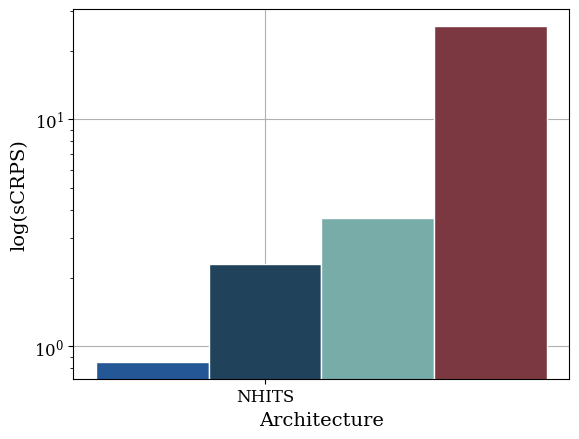

In [18]:
# set heights of bars
bar_heights = [overall_result_df[models].values[i] for i in range(num_bars)]

# Set position of bars on X axis
r1 = np.arange(num_models)
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
bar_pos = [r1,r2,r3,r4]
 
# Make the plot
fig, ax = plt.subplots(1, 1)
ax.grid(zorder=3)
ax.set_axisbelow(True)
for i in range(num_bars):
    ax.bar(x=bar_pos[i], height=bar_heights[i], color=bar_colors[i],
           width=barWidth, edgecolor='white', label=f'{scalar_types[i]}')
    
#set the y-axis to be log scale
ax.set_yscale('log')

# Add xticks on the middle of the group bars
plt.xlabel('Architecture', fontsize=14)
plt.ylabel('log(sCRPS)', fontsize=14)
plt.xticks(ticks=[r + barWidth for r in range(num_models)], 
           labels=architectures, fontsize=12)
plt.yticks(fontsize=12)
 

# Create legend & Show graphic
# legend = plt.legend(bbox_to_anchor=(0.25, 1.85, 1., .12), loc='upper left',
#            ncol=1, borderaxespad=0, fontsize=18)

plt.show()

In [19]:
fig.savefig(f'./data/AblationScale{dataset}.pdf', bbox_inches='tight', pad_inches = 0.01)